# <center> Crack Detection with Transfer Learning (ResNet50)
Crack detection has vital importance for structural health monitoring and inspection. In this notebook, I will build an image classifier using specific blocks from the ResNet50 layers and evaluate its performance using only one epoch. Images with cracks are denoted as positive and images without cracks as negative.

In [2]:
import pandas as pd
import numpy as np

from PIL import Image
import matplotlib.pylab as plt
from matplotlib.pyplot import imshow

import tensorflow as tf
from keras import layers, Model
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPooling2D
from keras.applications.resnet import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop

<a>

## Downloading Data

In [ ]:
!gdown --id 1ZZFrPVMjBpBEDlV_5lTMaHpiU4SOubul

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Traceback (most recent call last):
  File "/usr/local/bin/gdown", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/gdown/__main__.py", line 172, in main
    download(
  File "/usr/local/lib/python3.11/dist-packages/gdown/download.py", line 202, in download
    res = sess.get(url, stream=True, verify=verify)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/requests/sessions.py", line 602, in get
    return self.request("GET", url, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/requests/sessions.py", line 589, in request
    resp = self.send(prep, **send_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
 

In [ ]:
!unzip concrete_data.zip &> /dev/null

<a>

## Constructing ImageDataGenerator Instances


In [1]:
from google.colab import files
uploaded = files.upload()

Saving concrete_data.zip to concrete_data.zip


In [104]:
data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input
    )

In [105]:
#defining global constants
num_classes = 2

image_resize = 224

batch_size_training = 100
batch_size_validation = 100

### Training set

In [106]:
import os
print(os.listdir())  # Lists files in the current working directory



['.config', 'concrete_data', 'classifier_ResNet50_model.h5', 'concrete_data.zip', 'sample_data']


In [107]:
import zipfile

zip_path = "concrete_data.zip"  # Make sure this is the correct filename

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(".")  # Extracts to the current directory

print("Extraction complete!")



Extraction complete!


In [108]:
train_generator = data_generator.flow_from_directory(
    'concrete_data/train',
    target_size=(image_resize, image_resize),
    batch_size=batch_size_training,
    class_mode='binary'  # Change from 'categorical' to 'binary'
)

train_generator.class_indices

Found 30000 images belonging to 2 classes.


{'negative': 0, 'positive': 1}

In [109]:
#checking if the training set is balanced
pd.Series(train_generator.labels).value_counts()

0    15000
1    15000
Name: count, dtype: int64

### Validation set


In [110]:
validation_generator = data_generator.flow_from_directory(
    'concrete_data/valid',
    target_size=(image_resize, image_resize),
    batch_size=batch_size_training,
    class_mode='binary')

Found 9500 images belonging to 2 classes.


<a>

## Displaying and Analyzing  the Images
####Images without cracks

In [111]:
train_paths = train_generator.filepaths
train_paths[0:2]

['concrete_data/train/negative/00001.jpg',
 'concrete_data/train/negative/00002.jpg']

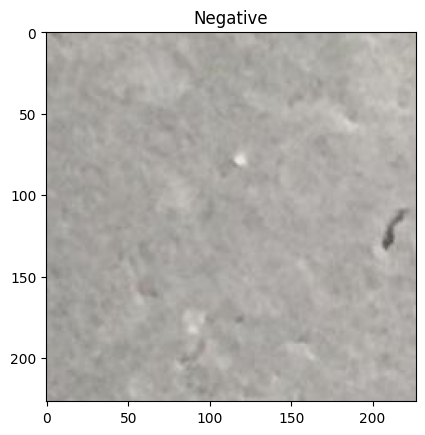

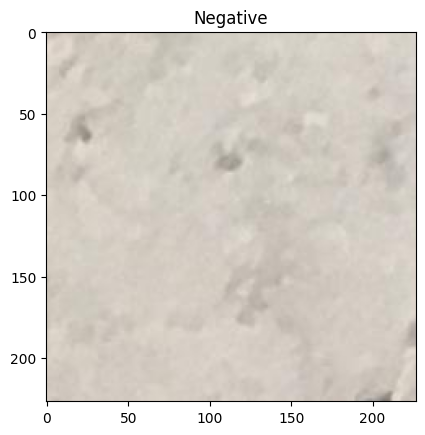

In [112]:
counter = 0
for i in train_paths:
  if "negative" in i:
      img=Image.open(i)
      plt.imshow(img)
      plt.title("Negative")
      plt.show()
      counter += 1
      if counter == 2:
        break #breaking after displaying two images

####Images with cracks

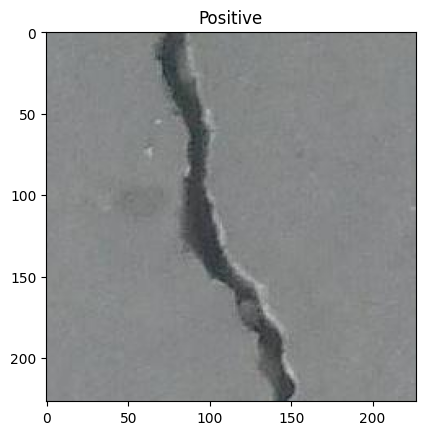

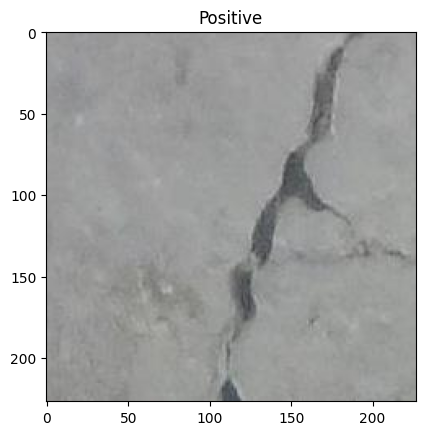

In [113]:
counter = 0
for i in train_paths:
  if "positive" in i:
      img=Image.open(i)
      plt.imshow(img)
      plt.title("Positive")
      plt.show()
      counter += 1
      if counter == 2:
        break #breaking after displaying two images

<a>

## Building & Compiling the Model


In [114]:
pre_trained_model = ResNet50(input_shape = (image_resize, image_resize, 3),
                                include_top = False,
                                weights = 'imagenet')

for layer in pre_trained_model.layers:
  layer.trainable = False

pre_trained_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [115]:
for layer in pre_trained_model.layers:
    print(layer.name)


input_layer_3
conv1_pad
conv1_conv
conv1_bn
conv1_relu
pool1_pad
pool1_pool
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_2_bn
conv2_block1_2_relu
conv2_block1_0_conv
conv2_block1_3_conv
conv2_block1_0_bn
conv2_block1_3_bn
conv2_block1_add
conv2_block1_out
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_2_bn
conv2_block2_2_relu
conv2_block2_3_conv
conv2_block2_3_bn
conv2_block2_add
conv2_block2_out
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_2_bn
conv2_block3_2_relu
conv2_block3_3_conv
conv2_block3_3_bn
conv2_block3_add
conv2_block3_out
conv3_block1_1_conv
conv3_block1_1_bn
conv3_block1_1_relu
conv3_block1_2_conv
conv3_block1_2_bn
conv3_block1_2_relu
conv3_block1_0_conv
conv3_block1_3_conv
conv3_block1_0_bn
conv3_block1_3_bn
conv3_block1_add
conv3_block1_out
conv3_block2_1_conv
conv3_block2_1_bn
conv3_block2_1_relu
conv3_block2_2_conv
conv3_block2_2_bn


In [116]:
last_layer = pre_trained_model.get_layer('conv5_block3_out')  # Use last block's output
print('last layer output shape: ', last_layer.output.shape)
last_output = last_layer.output


last layer output shape:  (None, 7, 7, 2048)


In [117]:
# Flattening the output layer to 1 dimension
x = layers.Flatten()(last_output)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)

model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,688,065 (90.36 MB)

 Trainable params: 100,353 (392.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [118]:
model.compile(optimizer = RMSprop(learning_rate=0.0001, momentum=0.9),
              loss = "binary_crossentropy",
              metrics = ['acc'])

<a>

## Fitting the Model

In [119]:
steps_per_epoch_training = len(train_generator)
steps_per_epoch_validation = len(validation_generator)
num_epochs = 5

In [120]:
from keras.callbacks import Callback

class Histories(Callback):
    def on_train_begin(self,logs={}):
        self.losses = []
        self.accuracies = []
    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.accuracies.append(logs.get('acc'))
histories = Histories()

fit_history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch_training,
    epochs=num_epochs,
    validation_data=validation_generator,
    validation_steps=steps_per_epoch_validation,
    verbose=1,
    callbacks=[histories]
)

Epoch 1/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 136s 414ms/step - acc: 0.9820 - loss: 0.0524 - val_acc: 0.9983 - val_loss: 0.0145
Epoch 2/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 118s 393ms/step - acc: 0.9989 - loss: 0.0061 - val_acc: 0.9983 - val_loss: 0.0175
Epoch 3/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 142s 391ms/step - acc: 0.9995 - loss: 0.0031 - val_acc: 0.9975 - val_loss: 0.0287
Epoch 4/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 143s 393ms/step - acc: 0.9997 - loss: 0.0014 - val_acc: 0.9974 - val_loss: 0.0284
Epoch 5/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 143s 398ms/step - acc: 0.9996 - loss: 0.0025 - val_acc: 0.9982 - val_loss: 0.0200


<a>

## Visualising Loss/Accuracy at each iteration

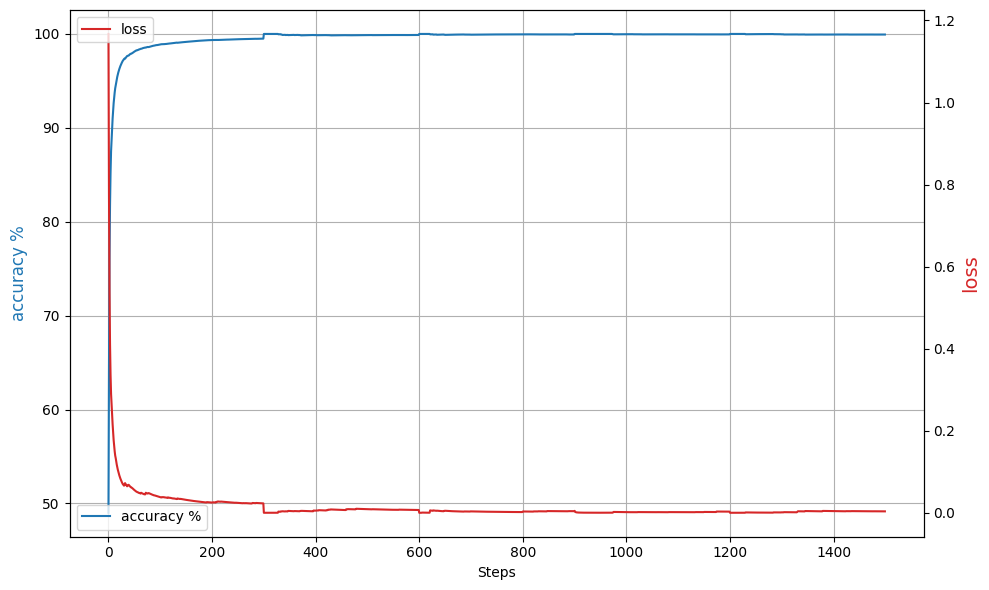

In [121]:
data1 = [i * 100 for i in histories.accuracies]
data2 = histories.losses

fig, ax1 = plt.subplots(figsize = (10,6))
color = 'tab:blue'
ax1.set_xlabel('Steps')
ax1.set_ylabel('accuracy %', color=color, size=12)
ax1.plot(data1, color=color)
ax1.grid()
ax1.legend(['accuracy %'],loc='lower left')

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('loss', color=color, size=14)
ax2.plot(data2, color=color)
ax2.legend(['loss'],loc='upper left')

fig.tight_layout()
plt.show()

<a>

## Saving the Model

In [130]:
model.save('classifier_ResNet50_model.h5')

In [131]:
ResNet50_model = load_model('classifier_ResNet50_model.h5')

<a>

## Generating Testing Set


In [132]:
test_generator = data_generator.flow_from_directory(
    'concrete_data/test',
    target_size=(image_resize, image_resize),
    class_mode='binary', shuffle=False,)

test_generator.class_indices

Found 500 images belonging to 2 classes.


{'negative': 0, 'positive': 1}

<a>

## Evaluating the Model


In [129]:
from tensorflow.keras import backend as K

# Before evaluating the model:
K.clear_session()

# Now run the evaluation:
ResNet50_evaluation = ResNet50_model.evaluate(test_generator)
print("Test Accuracy :", str(round(ResNet50_evaluation[1]*100, 2)),'%')

ValueError: Attr 'Toutput_types' of 'OptionalFromValue' Op passed list of length 0 less than minimum 1.

In [133]:
ResNet50_evaluation = ResNet50_model.evaluate(test_generator)

print("Test Accuracy :", str(round(ResNet50_evaluation[1]*100, 2)),'%')

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 247ms/step - acc: 1.0000 - loss: 6.8980e-06
Test Accuracy : 100.0 %


## Visualizing CNN layers

In [134]:
def display_activation(activations, col_size, row_size, act_index):

    activation = activations[act_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*2.5,col_size*1.5))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='Blues')
            activation_index += 1

### Original Image

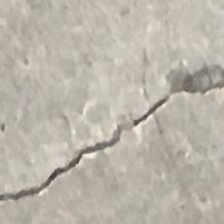

In [135]:
img_index = 454

img = Image.open(test_generator.filepaths[img_index])
img = img.resize((224, 224))
img_np = np.expand_dims(img, axis=0)

img

###Displaying some filters from the 10th layer

In [136]:
layer_outputs = [layer.output for layer in ResNet50_model.layers]
activation_model = Model(inputs=ResNet50_model.input, outputs=layer_outputs)
activations = activation_model.predict(img_np)

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


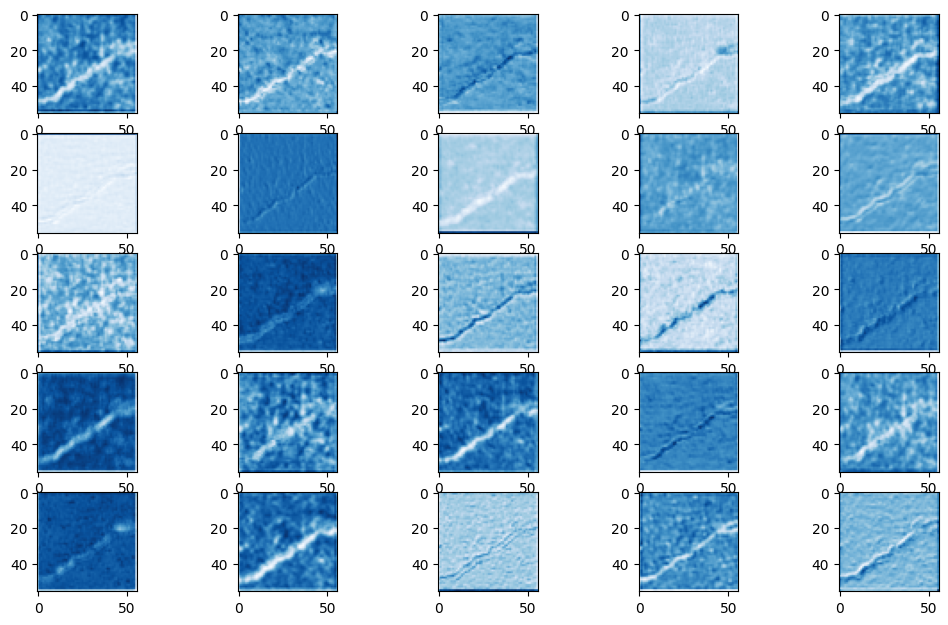

In [137]:
display_activation(activations, 5, 5, 10)

###Filters from the 110th layer

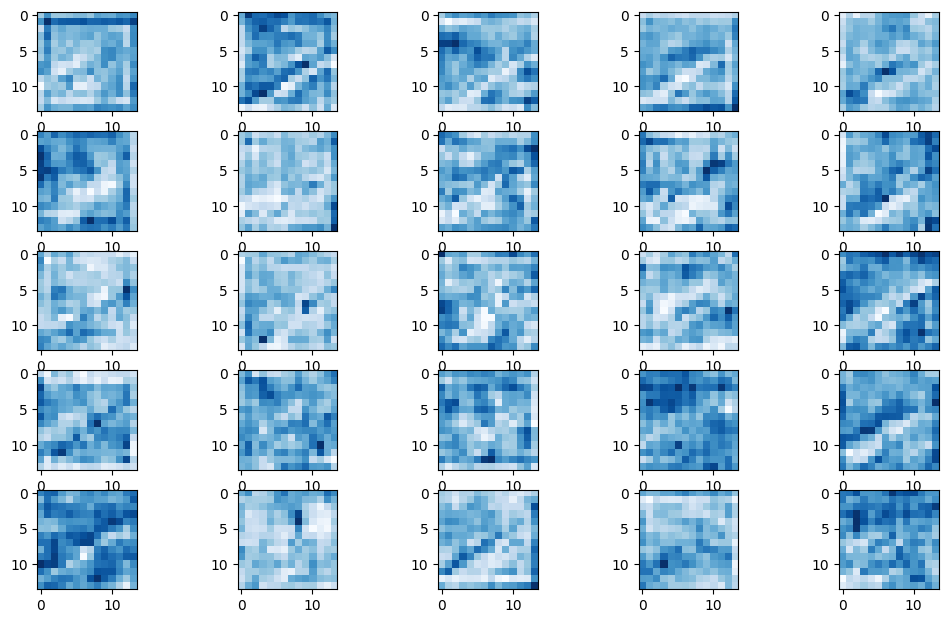

In [138]:
display_activation(activations, 5, 5, 110)

In [139]:
from tensorflow.keras.models import load_model

model = load_model("classifier_ResNet50_model.h5")  # Use the correct filename


In [32]:
from tensorflow.keras.models import load_model

# Load the model from the current directory
model = load_model("classifier_ResNet50_model.h5")



In [140]:
import os
print(os.getcwd())  # Print the current working directory
print(os.listdir())  # List all files in the current directory


/content
['.config', 'concrete_data', 'classifier_ResNet50_model.h5', 'concrete_data.zip', 'sample_data']


FileUpload(value={}, accept='image/*', description='Upload')

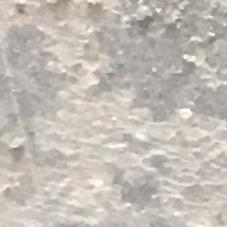

Image Shape: (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Prediction: Class B


In [145]:
import numpy as np
import tensorflow as tf
import ipywidgets as widgets
from IPython.display import display
from PIL import Image
from io import BytesIO

# Load the trained model
model = tf.keras.models.load_model("classifier_ResNet50_model.h5")

# Upload widget
upload_button = widgets.FileUpload(accept='image/*', multiple=False)

# Function to process and predict
def on_upload(change):
    try:
        uploaded_file = list(upload_button.value.values())[0]

        # Read image correctly
        image_bytes = BytesIO(uploaded_file['content'])
        image = Image.open(image_bytes)

        # Display uploaded image
        display(image)

        # Preprocess image
        image = image.convert("RGB")  # Ensure it's in RGB mode
        image = image.resize((224, 224))  # Resize to model's expected input size
        img_array = np.array(image) / 255.0  # Normalize
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Debug: Check array shape
        print(f"Image Shape: {img_array.shape}")

        # Make prediction
        prediction = model.predict(img_array)
        class_label = "Class A" if prediction[0][0] > 0.5 else "Class B"  # Example logic

        # Display result
        print(f"Prediction: {class_label}")

    except Exception as e:
        print(f"Error: {e}")

# Attach function to widget
upload_button.observe(on_upload, names='value')

# Display upload button
display(upload_button)




FileUpload(value={}, accept='image/*', description='Upload')

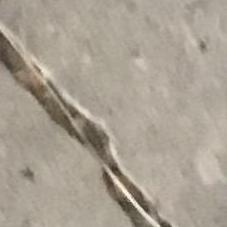

Image Shape: (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Prediction: Class B


In [146]:
import numpy as np
import tensorflow as tf
import ipywidgets as widgets
from IPython.display import display
from PIL import Image
from io import BytesIO

# Load the trained model
model = tf.keras.models.load_model("classifier_ResNet50_model.h5")

# Upload widget
upload_button = widgets.FileUpload(accept='image/*', multiple=False)

# Function to process and predict
def on_upload(change):
    try:
        uploaded_file = list(upload_button.value.values())[0]

        # Read image correctly
        image_bytes = BytesIO(uploaded_file['content'])
        image = Image.open(image_bytes)

        # Display uploaded image
        display(image)

        # Preprocess image
        image = image.convert("RGB")  # Ensure it's in RGB mode
        image = image.resize((224, 224))  # Resize to model's expected input size
        img_array = np.array(image) / 255.0  # Normalize
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Debug: Check array shape
        print(f"Image Shape: {img_array.shape}")

        # Make prediction
        prediction = model.predict(img_array)
        class_label = "Class A" if prediction[0][0] > 0.5 else "Class B"  # Example logic

        # Display result
        print(f"Prediction: {class_label}")

    except Exception as e:
        print(f"Error: {e}")

# Attach function to widget
upload_button.observe(on_upload, names='value')

# Display upload button
display(upload_button)




FileUpload(value={}, accept='image/*', description='Upload')

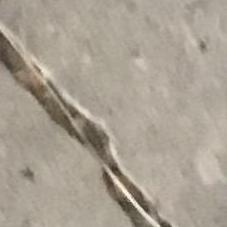

Image Shape: (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Processed Prediction: 0.7310585379600525
Prediction: Crack Detected


In [148]:
import numpy as np
import tensorflow as tf
import ipywidgets as widgets
from IPython.display import display
from PIL import Image
from io import BytesIO
from keras.applications.resnet import preprocess_input
# Load the trained model
model = tf.keras.models.load_model("classifier_ResNet50_model.h5")

# Upload widget
upload_button = widgets.FileUpload(accept='image/*', multiple=False)

# Function to process and predict
def on_upload(change):
    try:
        uploaded_file = list(upload_button.value.values())[0]

        # Read image correctly
        image_bytes = BytesIO(uploaded_file['content'])
        image = Image.open(image_bytes)

        # Display uploaded image
        display(image)

        # Preprocess image
        image = image.convert("RGB")  # Ensure it's in RGB mode
        image = image.resize((224, 224))  # Resize to model's expected input size
        img_array = np.array(image)   # Normalize
        img_array = preprocess_input(img_array)
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Debug: Check array shape
        print(f"Image Shape: {img_array.shape}")

        # Make prediction
        # Make prediction

        # prediction = model.predict(img_array)
        # print(f"Raw Prediction Output: {prediction[0][0]}")
        # probability = tf.nn.sigmoid(prediction[0][0]).numpy()
        # class_label = "Crack Detected" if probability > 0.8 else "No Crack Detected"
        # print(f"Processed Prediction: {probability}")
        # Convert prediction to Crack/No Crack
        # class_label = "Crack Detected" if prediction[0][0] > 0.5 else "No Crack Detected"
        # probability = model.predict(img_array)[0][0]
        # class_label = "Crack Detected" if probability > 0.5 else "No Crack Detected"
        # # Display result
        # print(f"Prediction: {class_label}")
        probability = tf.nn.sigmoid(model.predict(img_array)[0][0]).numpy()
        class_label = "Crack Detected" if probability > 0.5 else "No Crack Detected"

        print(f"Processed Prediction: {probability}")
        print(f"Prediction: {class_label}")

    except Exception as e:
        print(f"Error: {e}")

# Attach function to widget
upload_button.observe(on_upload, names='value')

# Display upload button
display(upload_button)


FileUpload(value={}, accept='image/*', description='Upload')

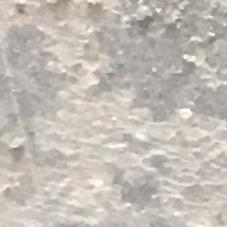

Image Shape: (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Processed Prediction: 0.5
Prediction: No Crack Detected


In [149]:
import numpy as np
import tensorflow as tf
import ipywidgets as widgets
from IPython.display import display
from PIL import Image
from io import BytesIO
from keras.applications.resnet import preprocess_input
# Load the trained model
model = tf.keras.models.load_model("classifier_ResNet50_model.h5")

# Upload widget
upload_button = widgets.FileUpload(accept='image/*', multiple=False)

# Function to process and predict
def on_upload(change):
    try:
        uploaded_file = list(upload_button.value.values())[0]

        # Read image correctly
        image_bytes = BytesIO(uploaded_file['content'])
        image = Image.open(image_bytes)

        # Display uploaded image
        display(image)

        # Preprocess image
        image = image.convert("RGB")  # Ensure it's in RGB mode
        image = image.resize((224, 224))  # Resize to model's expected input size
        img_array = np.array(image)   # Normalize
        img_array = preprocess_input(img_array)
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Debug: Check array shape
        print(f"Image Shape: {img_array.shape}")

        # Make prediction
        # Make prediction

        # prediction = model.predict(img_array)
        # print(f"Raw Prediction Output: {prediction[0][0]}")
        # probability = tf.nn.sigmoid(prediction[0][0]).numpy()
        # class_label = "Crack Detected" if probability > 0.8 else "No Crack Detected"
        # print(f"Processed Prediction: {probability}")
        # Convert prediction to Crack/No Crack
        # class_label = "Crack Detected" if prediction[0][0] > 0.5 else "No Crack Detected"
        # probability = model.predict(img_array)[0][0]
        # class_label = "Crack Detected" if probability > 0.5 else "No Crack Detected"
        # # Display result
        # print(f"Prediction: {class_label}")
        probability = tf.nn.sigmoid(model.predict(img_array)[0][0]).numpy()
        class_label = "Crack Detected" if probability > 0.5 else "No Crack Detected"

        print(f"Processed Prediction: {probability}")
        print(f"Prediction: {class_label}")

    except Exception as e:
        print(f"Error: {e}")

# Attach function to widget
upload_button.observe(on_upload, names='value')

# Display upload button
display(upload_button)


FileUpload(value={}, accept='image/*', description='Upload')

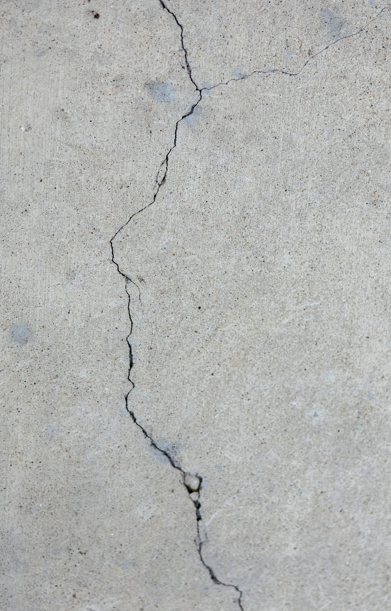

Image Shape: (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Processed Prediction: 0.7310585379600525
Prediction: Crack Detected


In [150]:
import numpy as np
import tensorflow as tf
import ipywidgets as widgets
from IPython.display import display
from PIL import Image
from io import BytesIO
from keras.applications.resnet import preprocess_input
# Load the trained model
model = tf.keras.models.load_model("classifier_ResNet50_model.h5")

# Upload widget
upload_button = widgets.FileUpload(accept='image/*', multiple=False)

# Function to process and predict
def on_upload(change):
    try:
        uploaded_file = list(upload_button.value.values())[0]

        # Read image correctly
        image_bytes = BytesIO(uploaded_file['content'])
        image = Image.open(image_bytes)

        # Display uploaded image
        display(image)

        # Preprocess image
        image = image.convert("RGB")  # Ensure it's in RGB mode
        image = image.resize((224, 224))  # Resize to model's expected input size
        img_array = np.array(image)   # Normalize
        img_array = preprocess_input(img_array)
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Debug: Check array shape
        print(f"Image Shape: {img_array.shape}")

        # Make prediction
        # Make prediction

        # prediction = model.predict(img_array)
        # print(f"Raw Prediction Output: {prediction[0][0]}")
        # probability = tf.nn.sigmoid(prediction[0][0]).numpy()
        # class_label = "Crack Detected" if probability > 0.8 else "No Crack Detected"
        # print(f"Processed Prediction: {probability}")
        # Convert prediction to Crack/No Crack
        # class_label = "Crack Detected" if prediction[0][0] > 0.5 else "No Crack Detected"
        # probability = model.predict(img_array)[0][0]
        # class_label = "Crack Detected" if probability > 0.5 else "No Crack Detected"
        # # Display result
        # print(f"Prediction: {class_label}")
        probability = tf.nn.sigmoid(model.predict(img_array)[0][0]).numpy()
        class_label = "Crack Detected" if probability > 0.5 else "No Crack Detected"

        print(f"Processed Prediction: {probability}")
        print(f"Prediction: {class_label}")

    except Exception as e:
        print(f"Error: {e}")

# Attach function to widget
upload_button.observe(on_upload, names='value')

# Display upload button
display(upload_button)


FileUpload(value={}, accept='image/*', description='Upload')

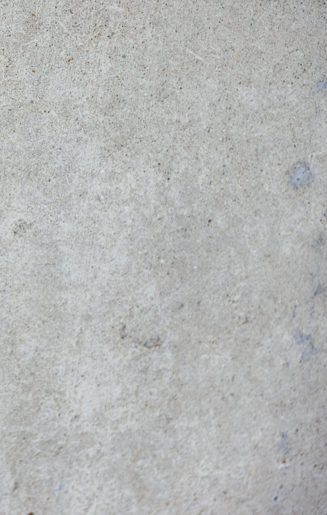

Image Shape: (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Processed Prediction: 0.5
Prediction: No Crack Detected


In [151]:
import numpy as np
import tensorflow as tf
import ipywidgets as widgets
from IPython.display import display
from PIL import Image
from io import BytesIO
from keras.applications.resnet import preprocess_input
# Load the trained model
model = tf.keras.models.load_model("classifier_ResNet50_model.h5")

# Upload widget
upload_button = widgets.FileUpload(accept='image/*', multiple=False)

# Function to process and predict
def on_upload(change):
    try:
        uploaded_file = list(upload_button.value.values())[0]

        # Read image correctly
        image_bytes = BytesIO(uploaded_file['content'])
        image = Image.open(image_bytes)

        # Display uploaded image
        display(image)

        # Preprocess image
        image = image.convert("RGB")  # Ensure it's in RGB mode
        image = image.resize((224, 224))  # Resize to model's expected input size
        img_array = np.array(image)   # Normalize
        img_array = preprocess_input(img_array)
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Debug: Check array shape
        print(f"Image Shape: {img_array.shape}")

        # Make prediction
        # Make prediction

        # prediction = model.predict(img_array)
        # print(f"Raw Prediction Output: {prediction[0][0]}")
        # probability = tf.nn.sigmoid(prediction[0][0]).numpy()
        # class_label = "Crack Detected" if probability > 0.8 else "No Crack Detected"
        # print(f"Processed Prediction: {probability}")
        # Convert prediction to Crack/No Crack
        # class_label = "Crack Detected" if prediction[0][0] > 0.5 else "No Crack Detected"
        # probability = model.predict(img_array)[0][0]
        # class_label = "Crack Detected" if probability > 0.5 else "No Crack Detected"
        # # Display result
        # print(f"Prediction: {class_label}")
        probability = tf.nn.sigmoid(model.predict(img_array)[0][0]).numpy()
        class_label = "Crack Detected" if probability > 0.5 else "No Crack Detected"

        print(f"Processed Prediction: {probability}")
        print(f"Prediction: {class_label}")

    except Exception as e:
        print(f"Error: {e}")

# Attach function to widget
upload_button.observe(on_upload, names='value')

# Display upload button
display(upload_button)


FileUpload(value={}, accept='image/*', description='Upload')

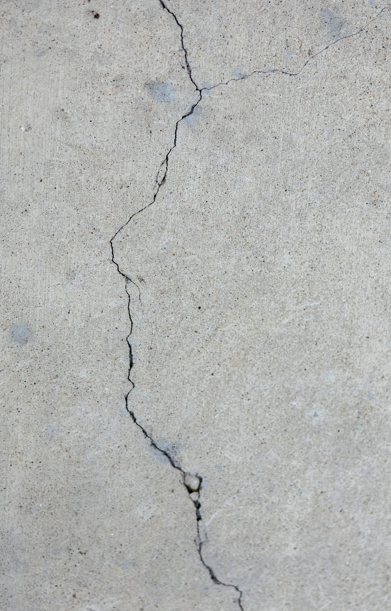

Image Shape: (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Processed Prediction: 0.7310585379600525
Prediction: Crack Detected


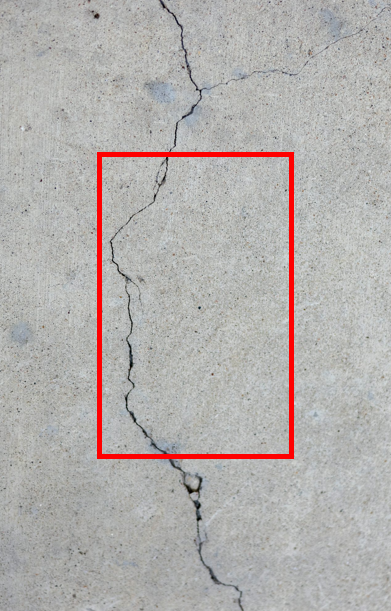

In [152]:
import numpy as np
import tensorflow as tf
import ipywidgets as widgets
from IPython.display import display
from PIL import Image, ImageDraw
from io import BytesIO
from keras.applications.resnet import preprocess_input

# Load the trained model
model = tf.keras.models.load_model("classifier_ResNet50_model.h5")

# Upload widget
upload_button = widgets.FileUpload(accept='image/*', multiple=False)

# Function to process and predict
def on_upload(change):
    try:
        uploaded_file = list(upload_button.value.values())[0]

        # Read image correctly
        image_bytes = BytesIO(uploaded_file['content'])
        image = Image.open(image_bytes)

        # Display uploaded image
        display(image)

        # Preprocess image
        image = image.convert("RGB")  # Ensure it's in RGB mode
        image_resized = image.resize((224, 224))  # Resize to model's expected input size
        img_array = np.array(image_resized)
        img_array = preprocess_input(img_array)  # Use ResNet50 preprocessing
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Debug: Check array shape
        print(f"Image Shape: {img_array.shape}")

        # Make prediction
        prediction = model.predict(img_array)

        # Convert logits to probability
        probability = tf.nn.sigmoid(prediction[0][0]).numpy()

        # Convert prediction to Crack/No Crack
        class_label = "Crack Detected" if probability > 0.5 else "No Crack Detected"

        # Display the result
        print(f"Processed Prediction: {probability}")
        print(f"Prediction: {class_label}")

        # Simulating the bounding box (just for visualization)
        if class_label == "Crack Detected":
            draw = ImageDraw.Draw(image)  # Draw on the original image
            width, height = image.size
            margin = 30  # Margin for bounding box

            # Define the bounding box coordinates (simulating a box for visualization)
            bbox = (width // 4, height // 4, width * 3 // 4, height * 3 // 4)

            # Draw the bounding box around the crack
            draw.rectangle(bbox, outline="red", width=5)

            # Display the image with bounding box
            display(image)

    except Exception as e:
        print(f"Error: {e}")

# Attach function to widget
upload_button.observe(on_upload, names='value')

# Display upload button
display(upload_button)


FileUpload(value={}, accept='image/*', description='Upload')

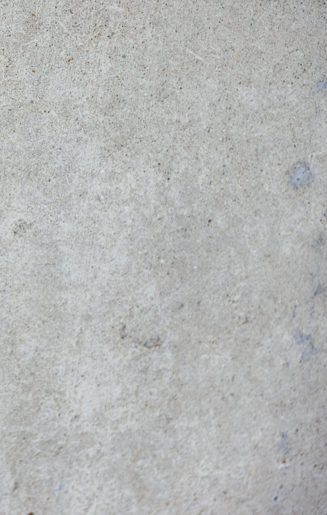

Image Shape: (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Processed Prediction: 0.5
Prediction: No Crack Detected


In [153]:
import numpy as np
import tensorflow as tf
import ipywidgets as widgets
from IPython.display import display
from PIL import Image, ImageDraw
from io import BytesIO
from keras.applications.resnet import preprocess_input

# Load the trained model
model = tf.keras.models.load_model("classifier_ResNet50_model.h5")

# Upload widget
upload_button = widgets.FileUpload(accept='image/*', multiple=False)

# Function to process and predict
def on_upload(change):
    try:
        uploaded_file = list(upload_button.value.values())[0]

        # Read image correctly
        image_bytes = BytesIO(uploaded_file['content'])
        image = Image.open(image_bytes)

        # Display uploaded image
        display(image)

        # Preprocess image
        image = image.convert("RGB")  # Ensure it's in RGB mode
        image_resized = image.resize((224, 224))  # Resize to model's expected input size
        img_array = np.array(image_resized)
        img_array = preprocess_input(img_array)  # Use ResNet50 preprocessing
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Debug: Check array shape
        print(f"Image Shape: {img_array.shape}")

        # Make prediction
        prediction = model.predict(img_array)

        # Convert logits to probability
        probability = tf.nn.sigmoid(prediction[0][0]).numpy()

        # Convert prediction to Crack/No Crack
        class_label = "Crack Detected" if probability > 0.5 else "No Crack Detected"

        # Display the result
        print(f"Processed Prediction: {probability}")
        print(f"Prediction: {class_label}")

        # Simulating the bounding box (just for visualization)
        if class_label == "Crack Detected":
            draw = ImageDraw.Draw(image)  # Draw on the original image
            width, height = image.size
            margin = 30  # Margin for bounding box

            # Define the bounding box coordinates (simulating a box for visualization)
            bbox = (width // 4, height // 4, width * 3 // 4, height * 3 // 4)

            # Draw the bounding box around the crack
            draw.rectangle(bbox, outline="red", width=5)

            # Display the image with bounding box
            display(image)

    except Exception as e:
        print(f"Error: {e}")

# Attach function to widget
upload_button.observe(on_upload, names='value')

# Display upload button
display(upload_button)
